# Draft of HW 6 / final midterm

In [267]:
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from mnist import MNIST
from sklearn import linear_model
from tabulate import tabulate


In [3]:
file_dir = '/Users/jmnugent/Documents/__Year_3_2020-2021/AMATH_584-Numerical_Linear_Algebra/Homework/python/amath584/hw6_regression_and_sparsity/'
data_dir = file_dir + 'data/'
save_dir = file_dir + 'figures/'


### Load in the MNIST data
This method comes from https://stackoverflow.com/questions/40427435/extract-images-from-idx3-ubyte-file-or-gzip-via-python and uses the **python-mnist** package (documentation here: https://pypi.org/project/python-mnist/).

In [4]:
# there are 60000 items in each training object
# and 10000 in the testing

mndata = MNIST('data')

train_imgs, train_labs = mndata.load_training()
test_imgs, test_labs = mndata.load_testing()

# the imgs are now arrays of arrays of integers for each picture
# the labels are now numpy arrays
train_imgs = np.asarray(train_imgs)
test_imgs = np.asarray(test_imgs)
train_labs = np.asarray(train_labs)
test_labs = np.asarray(test_labs)


In [4]:
# check out the sizes
for x in [train_imgs, train_labs, test_imgs, test_labs]:
    print(x.shape)
    

(60000, 784)
(60000,)
(10000, 784)
(10000,)


#### Vectorize and reshape the MNIST images to make the matrix A
* B = [$y_1$, $y_2$, ..., $y_n$], which is the set of output (column) vectors; [0, ..., 0, 1] for 0, [1, 0, ..., 0] for 1, [0, 1, 0, ..., 0] for 2, etc.
    * these are the LABELS!

    
* X = [$x_1$, $x_2$, ..., $x_n$], where each $x_n$ is a vector reshaped from an nxn image
    * here, this is 28x28 such that each image has 784 entries
    * these are the IMAGES!

In [5]:
# get the size and dimensions for each picture (n x n)
ntrain, n2 = train_imgs.shape
n = int(np.sqrt(n2)) 
ntest = test_imgs.shape[0]


##### Need to turn the list of labels into vectors

In [6]:
def convert_label(label):
    """Convert an integer label (0-9) into a vector.
    """
    vector = np.zeros(10)
    vector[label-1] = 1

    return vector


In [7]:
def reshape_pic(array, n=28):
    """Reshaped input array into nxn array
    """
    new = np.reshape(array, (n, n))
    
    return new


In [8]:
def set_label(vec):
    """
    Assigns the 0-9 label to the label vector based on which
    entry has the largest magnitude.
    """
    ind = np.where(np.abs(vec) == np.max(np.abs(vec)))[0][0]
    if ind == 9:
        label = 0
    else:
        label = ind+1
    
    return label
    

In [9]:
B_train = np.zeros((ntrain, 10))
B_test = np.zeros((ntest, 10))

for i in range(ntrain):
    B_train[i, :] = convert_label(train_labs[i])

for i in range(ntest):
    B_test[i, :] = convert_label(test_labs[i])
    

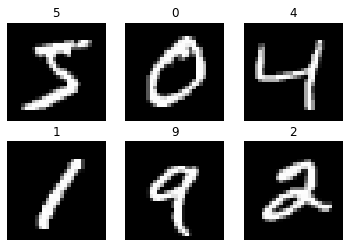

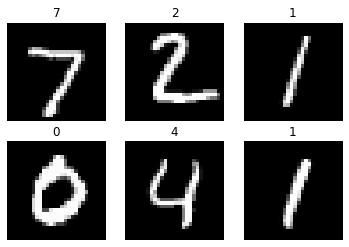

In [10]:
# plot the first few to see how they look

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    ax.imshow(reshape_pic(train_imgs[i]), cmap='gray')
    ax.set_title(train_labs[i])
    ax.axis('off')
    
plt.show()

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    ax.imshow(reshape_pic(test_imgs[i]), cmap='gray')
    ax.set_title(test_labs[i])
    ax.axis('off')
    
plt.show()



##### Check the shapes!
Should get A = (60,000 x 784), _x = (784 x 10)_, 
and B = (60,000 x 10)

* **A**: each row is an image and each column is a pixel
* **B**: each row is an image and each column is its label (0 or 1)
* **x**: THE WEIGHTS!!! eaach row is a pixel and each column is how much it should be weighted for that number

In [10]:
print(train_imgs.shape)
print(B_train.shape, '\n')

print(test_imgs.shape)
print(B_test.shape)

(60000, 784)
(60000, 10) 

(10000, 784)
(10000, 10)


# 1. Using various AX=B solvers, determine a mapping from the image space to the label space
As done in the lecture, let's try this for 4 things:
* (a) pinv (least squares) (np.linalg.pinv(A))
* (b-d) lasso with varying alpha (linear_model.Lasso())
* (e) ridge (linear_model.Ridge())

##### Count the number right/wrong
Use this to make a bar plot to compare accuracy of all the methods

In [11]:
def check_accuracy(labels, truth):
    """
    Returns the number of correct and incorrect labels.
        labels = 2D matrix of size (10, #samples) of the modeled labels
        truth = 1D list of the actual labels (0-9)
    Ex: [n_right, n_wrong] = check_accuracy(lasso_labs, test_labs)
    """
    n_right = 0
    n_wrong = 0
    
    for i in range(labels.shape[1]):
        error = set_label(labels[:, i]) - truth[i]
        if error == 0:
            n_right += 1
        else:
            n_wrong += 1
            
    return [n_right, n_wrong]


##### Bar plot of the loadings/coeff of matrix A (all 784)

In [12]:
def plot_loadings_bar(A, method, name, n=28, save=False,
                      save_dir=save_dir):
    """
    Bar plot of the loadings for each digit
    
        A = matrix of weights (10xn^2)
        method = method name (e.g. 'Lasso (alpha=0.1)')
        name = name for the file to save (e.g. 'lasso_01')
        n = dimension of picture in each direction (default=28 pixels)
        save = True if you want to save the image
        save_dir = directory to save the file to
    """
    if A.shape != (10, n**2):
        raise Exception('Weight matrix A has incorrect dimensions: {}'.format(A.shape))
    
    fig, axes = plt.subplots(2, 5, figsize=(18, 5))
    plt.subplots_adjust(hspace=0.5)
    
    for r in range(2):
        for c in range(5):
            ax = axes[r, c]
            
            if r == 0:
                i = c
            else:
                i = c+5
        
            ax.bar(np.arange(0, n**2), A[i, :].flatten())
            ax.axhline(0, linewidth=1, alpha=0.25, color='k')

            if i == 9:
                ax.set_title('0')
            else:
                ax.set_title(str(i+1))

            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])

    plt.suptitle(method, fontsize=18)
    
    if save:
        plt.savefig(save_dir + 'bar_plot_loadings_' + name + '.png', dpi=300,
                    bbox_inches='tight')
    
    plt.show()


###### Plot the weights/loadings/mapping for that method:
(Should give an idea of what the most important pixels are/what feeatures it's looking at to make a classification decision):

In [13]:
def plot_weights(A, method, name, n=28, save=False, no_zero=False, save_dir=save_dir):
    """
    Plot (and save) the weighhts for each method.
    
        A = matrix of weights (10xn^2)
        method = method name (e.g. 'Lasso (alpha=0.1)')
        name = name for the file to save (e.g. 'lasso_01')
        n = dimension of picture in each direction (default=28 pixels)
        save = True if you want to save the image
        no_zero = plot by omitting zeros (to see sparsity)
        save_dir = directory to save the file to
    """
    if A.shape != (10, n**2):
        raise Exception('Weight matrix A has incorrect dimensions: {}'.format(A.shape))
    
    if no_zero:
        A = np.where(A==0, np.nan, A)
        name += '_no_zeros'
    
    fig, axes = plt.subplots(2, 5, figsize=(12, 4))

    for r in range(2):
        for c in range(5):
            ax = axes[r, c]
            
            if r == 0:
                i = c
            else:
                i = c+5
        
            ax.set_aspect('equal')
            ax.pcolormesh(reshape_pic(A[i, :], n=n), cmap='gray')
        
            if i == 9:
                ax.set_title('0')
            else:
                ax.set_title(str(i+1))

            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])

    plt.suptitle(method)
    
    if save:
        plt.savefig(save_dir + 'weight_matrix_' + name + '.png', dpi=300,
                    bbox_inches='tight')
    plt.show()


##### Plot a histogram of nonzero weight values
Another way to get a sense of sparsity and the values of the weights for pixels that are the most important

In [14]:
def plot_hist_nonzero(A, method, name, save=False, save_dir=save_dir,
                      xlim=(-.02, .02)):
    """
    Plot (and save) a histogram of the aboslute value of nonzero points of the matrix.
    
        A = matrix of weights (10xn^2)
        method = method name (e.g. 'Lasso (alpha=0.1)')
        name = name for the file to save (e.g. 'lasso_01')
        save = True if you want to save the image
        save_dir = directory to save the file to
        xlim = limits on x axis (default=(-.02, .02), for pinv)
    """
    fig, axes = plt.subplots(2, 5, figsize=(12, 4))
    plt.subplots_adjust(hspace=0.6, wspace=0.4)
    
    for r in range(2):
        for c in range(5):
            ax = axes[r, c]
            
            if r == 0:
                i = c
            else:
                i = c+5
                
            flat = A[i, :].flatten()
            nonzero = flat[flat != 0.0]
            ax.hist(nonzero, bins=100)
            
            ax.set_yscale('log')
            ax.set_ylim((1, 1000))
            ax.set_xlim(xlim)
        
            if i == 9:
                ax.set_title('0')
            else:
                ax.set_title(str(i+1))

    plt.suptitle('Histogram of nonzero loadings ({})'.format(method))
    
    if save:
        plt.savefig(save_dir + 'nonzero_hist_' + name + '.png', dpi=300,
                    bbox_inches='tight')

    plt.show()    


### (a) pinv
Example from the data book:
    
    A = label @ np.linalg.pinv(train)
    test_labels = np.sign(A@test)

In [15]:
A_pinv = B_train.T @ np.linalg.pinv(train_imgs.T)
pinv_labs = A_pinv @ test_imgs.T


In [16]:
# how accurate was it?

[pinv_corr, pinv_wrong] = check_accuracy(pinv_labs, test_labs)

print(str(pinv_corr/(pinv_corr+pinv_wrong)*100.) + '% correct')


85.25% correct


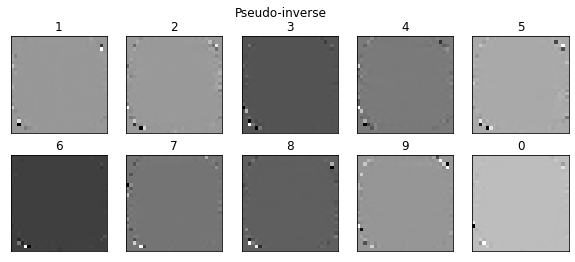

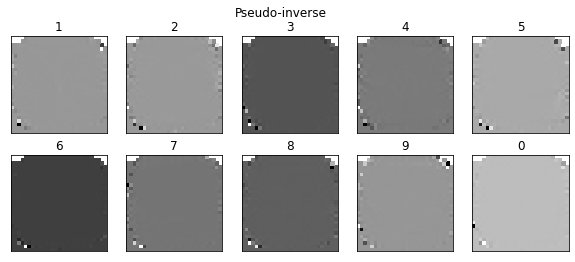

In [270]:
# check out what the weights look like - should show you 
# the important pixels!

plot_weights(A_pinv, 'Pseudo-inverse', 'pinv', save=True)
plot_weights(A_pinv, 'Pseudo-inverse', 'pinv', no_zero=True, save=True)


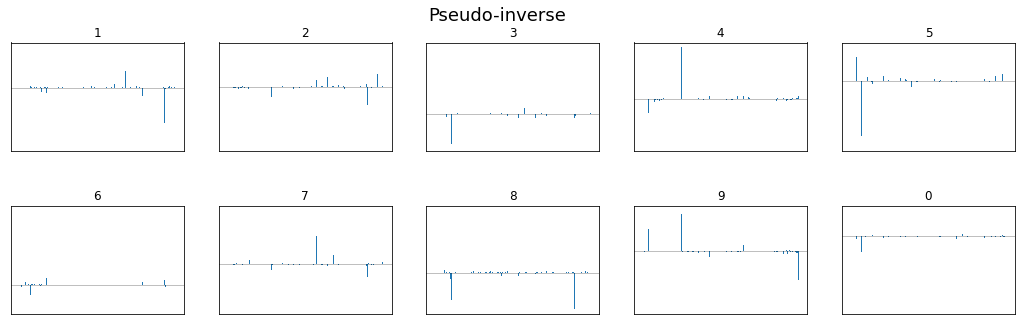

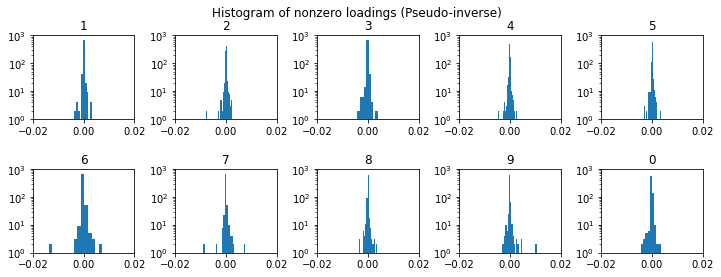

In [461]:
# some accuracy plots, etc...

plot_loadings_bar(A_pinv, 'Pseudo-inverse', 'pinv', save=True)
plot_hist_nonzero(A_pinv, 'Pseudo-inverse', 'pinv', save=True)


### (b) Lasso, alpha=1.0
Example from the data book:

    lasso = linear_model.Lasso().fit(train.T,label)
    A_lasso = lasso.coef_
    test_labels_lasso = np.sign(A_lasso@test)

In [17]:
lasso = linear_model.Lasso().fit(train_imgs, B_train)
A_lasso = lasso.coef_
lasso_labs_1 = A_lasso @ test_imgs.T


In [18]:
# how accurate was it?

[lasso1_corr, lasso1_wrong] = check_accuracy(lasso_labs_1, test_labs)

print(str(lasso1_corr/(lasso1_corr+lasso1_wrong)*100.) + '% correct')


74.48% correct


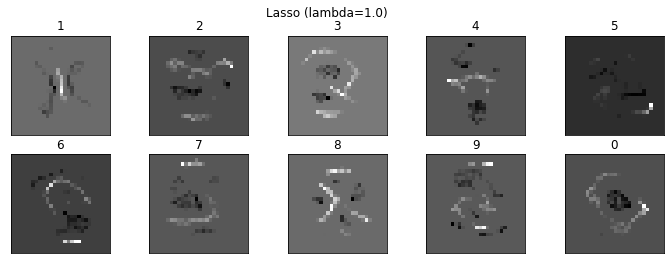

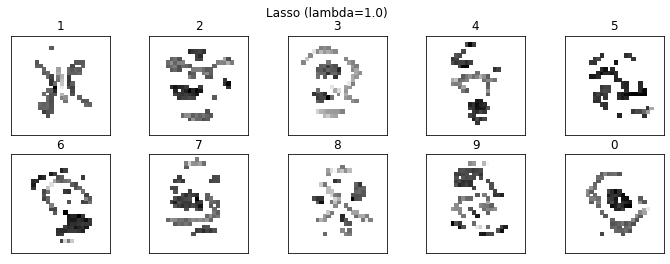

In [332]:
# check out what the weights look like - should show you 
# the important pixels!

plot_weights(A_lasso, 'Lasso (lambda=1.0)', 'lasso_1', save=True)
plot_weights(A_lasso, 'Lasso (lambda=1.0)', 'lasso_1', no_zero=True, save=True)


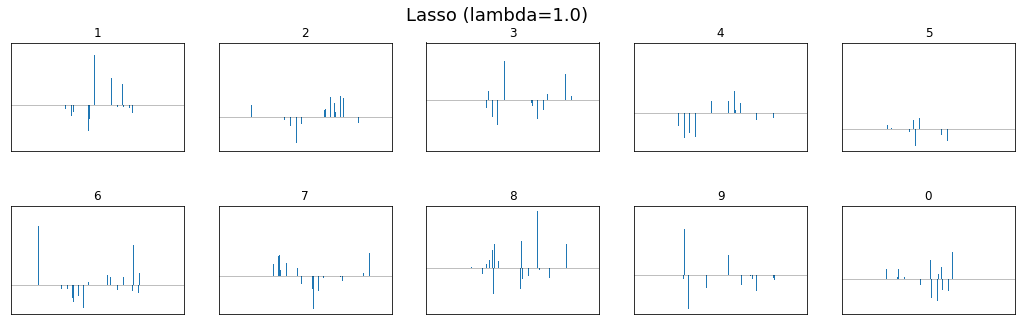

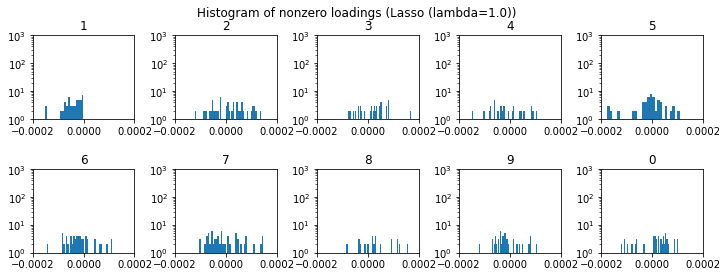

In [462]:
# some accuracy plots, etc...

plot_loadings_bar(A_lasso, 'Lasso (lambda=1.0)', 'lasso_1', save=True)
plot_hist_nonzero(A_lasso, 'Lasso (lambda=1.0)', 'lasso_1', xlim=(-2e-4, 2e-4),
                  save=True)


### (c) Lasso, alpha = 0.5
This is a lower weight for the L1 term than above. Solution should be LESS sparse.

In [19]:
lasso_05 = linear_model.Lasso(alpha=0.5).fit(train_imgs, B_train)
A_lasso_05 = lasso_05.coef_
lasso_labs_05 = A_lasso_05 @ test_imgs.T


In [20]:
# how accurate was it?

[lasso05_corr, lasso05_wrong] = check_accuracy(lasso_labs_05, test_labs)

print(str(lasso05_corr/(lasso05_corr+lasso05_wrong)*100.) + '% correct')


75.98% correct


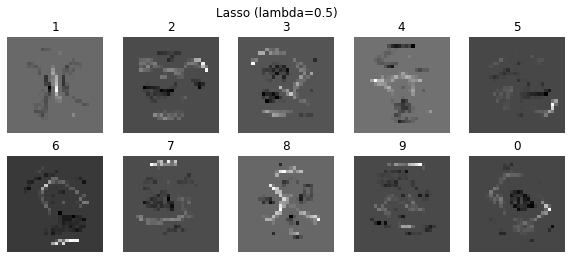

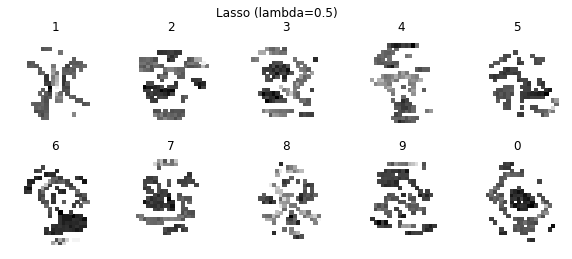

In [225]:
# check out what the weights look like - should show you 
# the important pixels!

plot_weights(A_lasso_05, 'Lasso (lambda=0.5)', 'lasso_05', save=True)
plot_weights(A_lasso_05, 'Lasso (lambda=0.5)', 'lasso_05', no_zero=True, save=True)


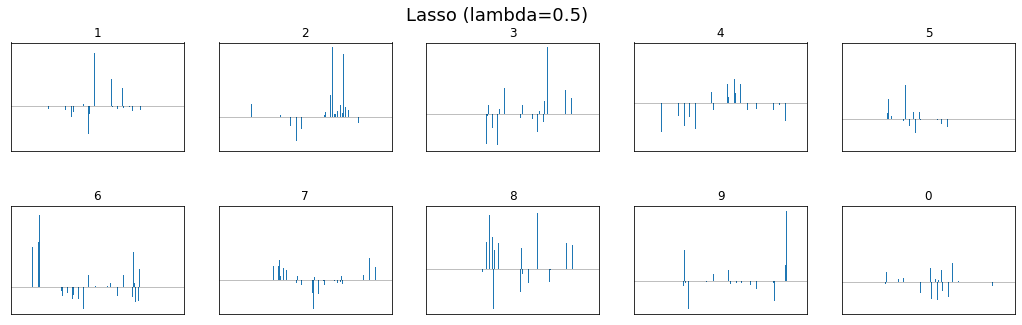

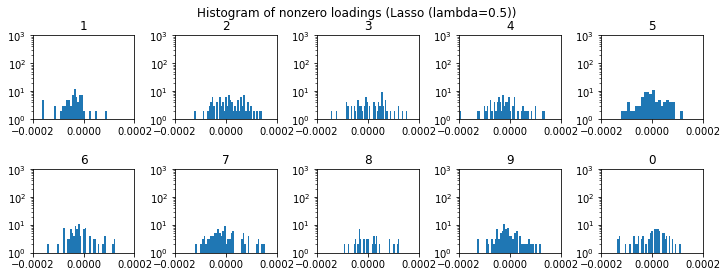

In [463]:
# some accuracy plots, etc...

plot_loadings_bar(A_lasso_05, 'Lasso (lambda=0.5)', 'lasso_05', save=True)
plot_hist_nonzero(A_lasso_05, 'Lasso (lambda=0.5)', 'lasso_05', xlim=(-2e-4, 2e-4),
                  save=True)


### (d) Lasso, alpha = 0.1
Even less of a weight on L1. Should be similar to the linear regression (pinv)

In [21]:
lasso_01 = linear_model.Lasso(alpha=0.1).fit(train_imgs, B_train)
A_lasso_01 = lasso_01.coef_
lasso_labs_01 = A_lasso_01 @ test_imgs.T


In [22]:
# how accurate was it?

[lasso01_corr, lasso01_wrong] = check_accuracy(lasso_labs_01, test_labs)

print(str(lasso01_corr/(lasso01_corr+lasso01_wrong)*100.) + '% correct')


77.71000000000001% correct


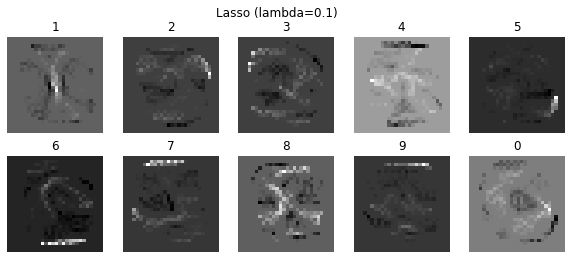

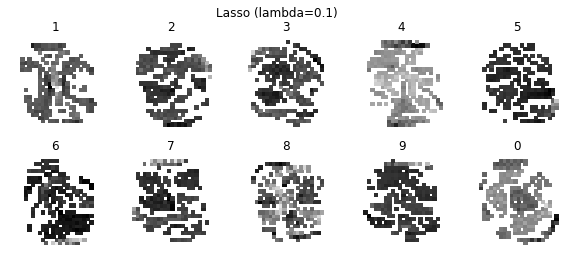

In [226]:
# check out what the weights look like - should show you 
# the important pixels!

plot_weights(A_lasso_01, 'Lasso (lambda=0.1)', 'lasso_01', save=True)
plot_weights(A_lasso_01, 'Lasso (lambda=0.1)', 'lasso_01', no_zero=True, save=True)


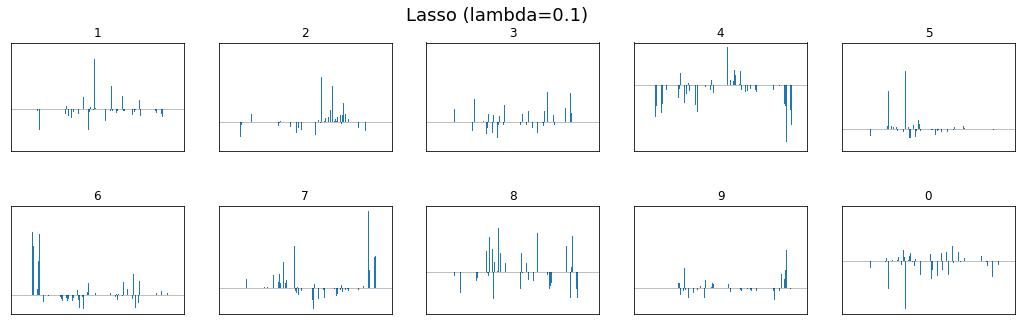

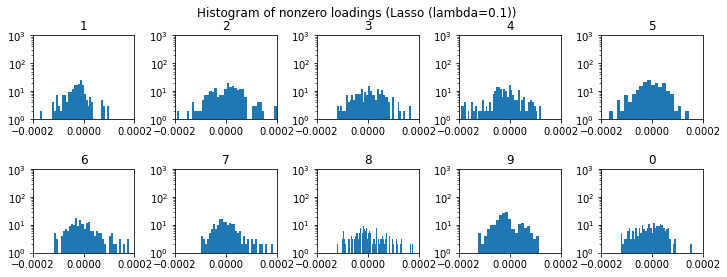

In [464]:
# some accuracy plots, etc...

plot_loadings_bar(A_lasso_01, 'Lasso (lambda=0.1)', 'lasso_01', save=True)
plot_hist_nonzero(A_lasso_01, 'Lasso (lambda=0.1)', 'lasso_01', xlim=(-2e-4, 2e-4),
                  save=True)


### (e) Ridge
"Linear least squares with L2 regularization"
    

In [23]:
# ridge = linear_model.Ridge().fit(train_imgs, train_labs)
ridge = linear_model.Ridge().fit(train_imgs, B_train)
A_ridge = ridge.coef_
ridge_labs = A_ridge @ test_imgs.T


In [24]:
# how accurate was it?

[ridge_corr, ridge_wrong] = check_accuracy(ridge_labs, test_labs)

print(str(ridge_corr/(ridge_corr+ridge_wrong)*100.) + '% correct')


77.62% correct


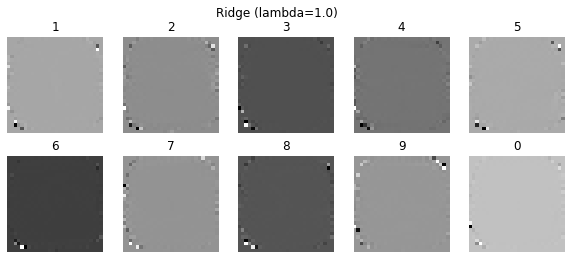

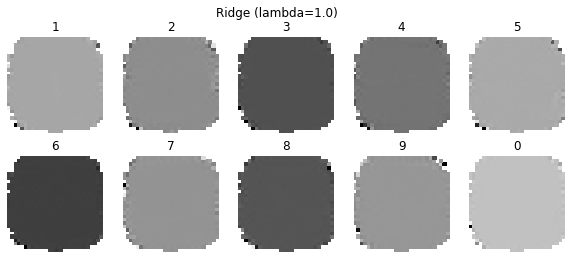

In [227]:
# check out what the weights look like - should show you 
# the important pixels!

plot_weights(A_ridge, 'Ridge (lambda=1.0)', 'ridge', save=True)
plot_weights(A_ridge, 'Ridge (lambda=1.0)', 'ridge', no_zero=True, save=True)


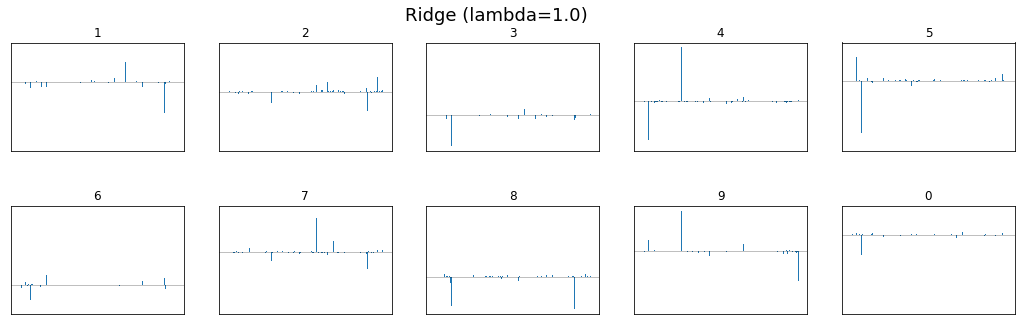

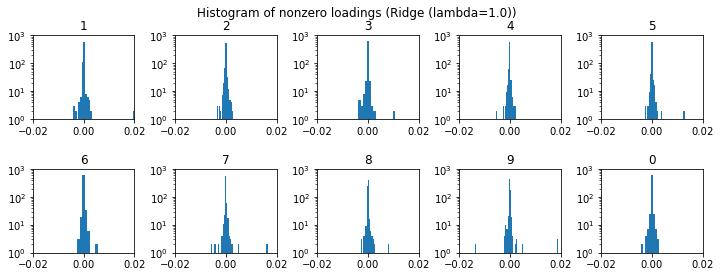

In [467]:
# some accuracy plots, etc...

plot_loadings_bar(A_ridge, 'Ridge (lambda=1.0)', 'ridge', save=True)
plot_hist_nonzero(A_ridge, 'Ridge (lambda=1.0)', 'ridge', save=True)


# 2. By promoting sparsity, determine and rank which pixels in the MNIST set are most informative for correctly labeling the digits.
(You’ll have to come up with your own heuristics or empirical rules for this. Use pcolor to help you visualize the results from X)

# TODO: Plot of the accuracy of lasso with increasing lambda/alpha? Might be good to include in the sparsity section?

##### Look at overall accuracy
This kind of falls under #1, but whatever...

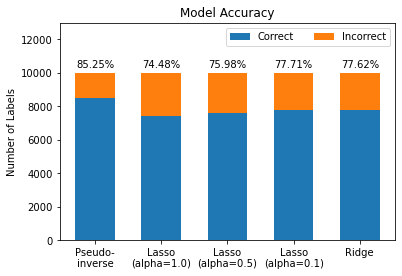

In [427]:
fig, ax = plt.subplots(figsize=(6, 4))

corr_counts = [pinv_corr, lasso1_corr, lasso05_corr, lasso01_corr, ridge_corr]
wrong_counts = [pinv_wrong, lasso1_wrong, lasso05_wrong, lasso01_wrong, ridge_wrong]

inds = np.arange(len(corr_counts))
width = 0.6

rects1 = ax.bar(inds, corr_counts, width, color='C0')
rects2 = ax.bar(inds, wrong_counts, width, bottom=corr_counts, color='C1')

ax.set_xticks(np.arange(0, len(corr_counts)))
ax.set_xticklabels(['Pseudo-\ninverse', 'Lasso\n(alpha=1.0)', 'Lasso\n(alpha=0.5)',
                    'Lasso\n(alpha=0.1)', 'Ridge'])

ax.set_ylabel('Number of Labels')
plt.legend([rects1[0], rects2[0]], ['Correct', 'Incorrect'], loc='upper right', ncol=2)
ax.set_title('Model Accuracy')
ax.set_ylim(0, 13000)


# label for accuracy
# https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
accuracy = [(corr_counts[i]/(corr_counts[i]+wrong_counts[i]))*100. for i in range(len(corr_counts))]
accuracy_labs = ['{:.2f}%'.format(x) for x in accuracy]
for i in range(len(rects2)):
    height = rects1[i].get_height() + rects2[i].get_height()
    ax.annotate(accuracy_labs[i],
                xy=(rects2[i].get_x() + rects2[i].get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points',
                ha='center', va='bottom')

plt.savefig(save_dir + 'all_data_accuracy_comparison.png', dpi=300, bbox_inches='tight')

plt.show()


###### Look at sparsity 
(but none of this is surprising! This is exactly what you'd expect based on the behavior of each regularizer)
(and what you can see from the plots above!!)

In [25]:
def num_zeros(A):
    """ Print number of zero weights for each digit
    """
    num_zeros = np.zeros(10)
    for i in range(10):
        num_zeros[i] = len(A[i, :][A[i, :] == 0])
    
    print(num_zeros)
    

In [26]:
# from most to least sparse:

num_zeros(A_lasso)
num_zeros(A_lasso_01)
num_zeros(A_lasso_05)
num_zeros(A_ridge)
num_zeros(A_pinv)


[710. 687. 697. 711. 712. 697. 690. 708. 696. 699.]
[565. 552. 560. 536. 575. 562. 562. 566. 554. 550.]
[685. 649. 661. 662. 675. 656. 657. 672. 658. 664.]
[67. 67. 67. 67. 67. 67. 67. 67. 67. 67.]
[14. 14. 14. 14. 14. 14. 14. 14. 14. 14.]


# 3. Apply your most important pixels to the test data set to see how accurate you are with as few pixels as possible.
This is kind of one and the same with the points above... the plots all kind of blend in...

Ignoring how much less accurate the pseudoinverse/ridge are since those do't promote sparsity to begin with...

#### Look at only the top 90th percentile

In [27]:
# pick most important pixels by using some percentile as a treshold

pct = 90

pinv_pct = np.percentile(np.abs(A_pinv.flatten()), pct)
lasso_pct_1 = np.percentile(np.abs(A_lasso.flatten()), pct)
lasso_pct_05 = np.percentile(np.abs(A_lasso_05.flatten()), pct)
lasso_pct_01 = np.percentile(np.abs(A_lasso_01.flatten()), pct)
ridge_pct = np.percentile(np.abs(A_ridge.flatten()), pct)

new_A_pinv = np.where(A_pinv > pinv_pct, A_pinv,  0)
new_A_lasso_1 = np.where(A_lasso > lasso_pct_1, A_lasso,  0)
new_A_lasso_05 = np.where(A_lasso_05 > lasso_pct_05, A_lasso_05,  0)
new_A_lasso_01 = np.where(A_lasso_01 > lasso_pct_01, A_lasso_05,  0)
new_A_ridge = np.where(A_ridge > ridge_pct, A_ridge,  0)

new_pinv_labs = new_A_pinv @ test_imgs.T
new_lasso_labs = new_A_lasso_1 @ test_imgs.T
new_lasso_05_labs = new_A_lasso_05 @ test_imgs.T
new_lasso_01_labs = new_A_lasso_01 @ test_imgs.T
new_ridge_labs = new_A_ridge @ test_imgs.T


In [28]:
lab_list = [new_pinv_labs, new_lasso_labs, new_lasso_05_labs,
            new_lasso_01_labs, new_ridge_labs]

new_corr_counts = [[]]*len(lab_list)
new_wrong_counts = [[]]*len(lab_list)

for i in range(len(lab_list)):
    new_corr_counts[i], new_wrong_counts[i] = check_accuracy(lab_list[i], test_labs)
    

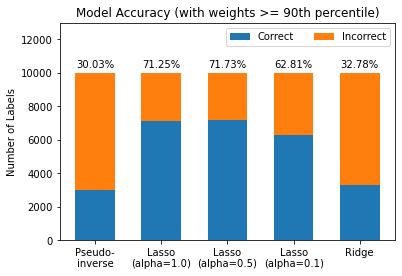

In [535]:
fig, ax = plt.subplots(figsize=(6, 4))

inds = np.arange(len(corr_counts))
width = 0.6

rects1 = ax.bar(inds, new_corr_counts, width, color='C0')
rects2 = ax.bar(inds, new_wrong_counts, width, bottom=new_corr_counts, color='C1')

ax.set_xticks(np.arange(0, len(new_corr_counts)))
ax.set_xticklabels(['Pseudo-\ninverse', 'Lasso\n(alpha=1.0)', 'Lasso\n(alpha=0.5)',
                    'Lasso\n(alpha=0.1)', 'Ridge'])

ax.set_ylabel('Number of Labels')
plt.legend([rects1[0], rects2[0]], ['Correct', 'Incorrect'], loc='upper right', ncol=2)
ax.set_title('Model Accuracy (with weights >= {}th percentile)'.format(pct))
ax.set_ylim(0, 13000)


# label for accuracy
# https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
accuracy = [(new_corr_counts[i]/(new_corr_counts[i]+new_wrong_counts[i]))*100. for i in range(len(new_corr_counts))]
accuracy_labs = ['{:.2f}%'.format(x) for x in accuracy]
for i in range(len(rects2)):
    height = rects1[i].get_height() + rects2[i].get_height()
    ax.annotate(accuracy_labs[i],
                xy=(rects2[i].get_x() + rects2[i].get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points',
                ha='center', va='bottom')

plt.savefig(save_dir + 'geq_{}th_pct_accuracy_comparison.png'.format(pct), dpi=300, bbox_inches='tight')

plt.show()


In [29]:
# from most to least sparse with the cuttoff:

print('{}th percentile'.format(pct))
num_zeros(new_A_lasso_1)
num_zeros(new_A_lasso_01)
num_zeros(new_A_lasso_05)
num_zeros(new_A_ridge)
num_zeros(new_A_pinv)


90th percentile
[771. 732. 733. 754. 753. 749. 744. 739. 751. 732.]
[766. 750. 752. 758. 760. 748. 753. 747. 754. 761.]
[768. 727. 732. 752. 751. 745. 746. 740. 749. 744.]
[753. 731. 745. 756. 741. 742. 731. 749. 745. 750.]
[747. 733. 744. 754. 733. 739. 731. 751. 741. 750.]


##### Plot these "most important" pixels

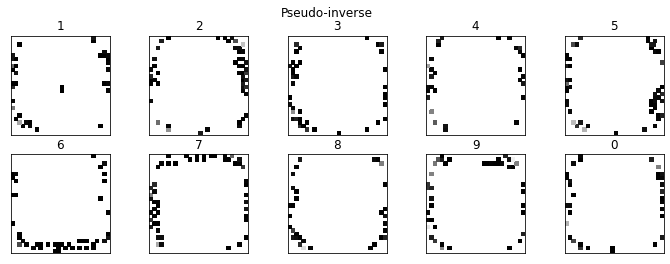

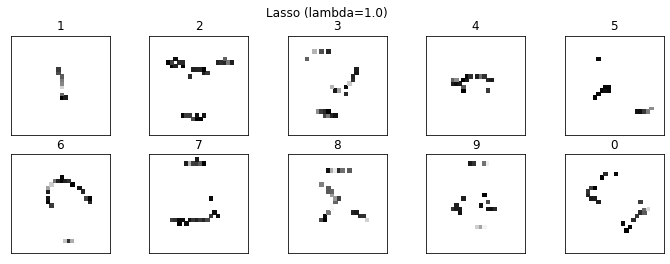

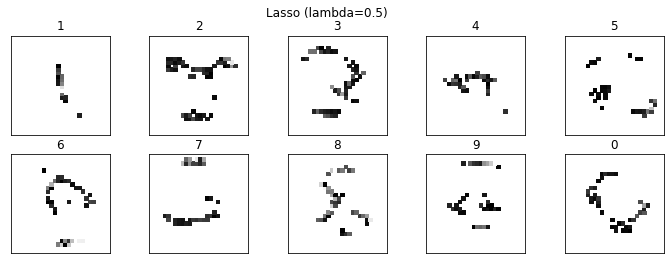

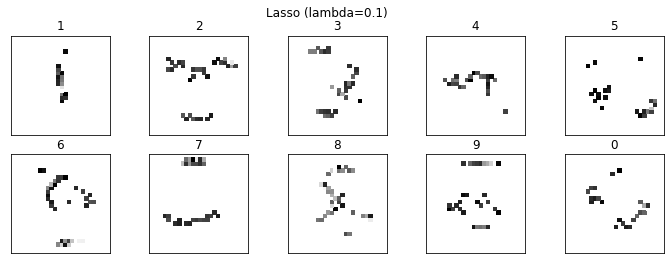

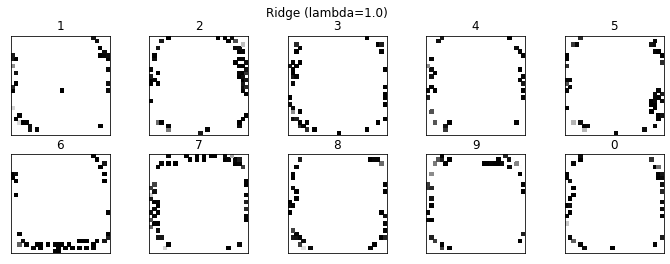

In [545]:
plot_weights(new_A_pinv, 'Pseudo-inverse', 'pinv_geq_90th', no_zero=True, save=True)
plot_weights(new_A_lasso, 'Lasso (lambda=1.0)', 'lasso_1_geq_90th', no_zero=True, save=True)
plot_weights(new_A_lasso_05, 'Lasso (lambda=0.5)', 'lasso_05_geq_90th', no_zero=True, save=True)
plot_weights(new_A_lasso_01, 'Lasso (lambda=0.1)', 'lasso_01_geq_90th', no_zero=True, save=True)
plot_weights(new_A_ridge, 'Ridge (lambda=1.0)', 'ridge_geq_90th', no_zero=True, save=True)



#### Test the cutoff with Lasso (alpha = 1.0)
See accuracy with all points, 90th, 95th, 97th, 99th
(and note that anything below the ~89.5th percentile for this one is 0, so it wouldn't be included anyway)

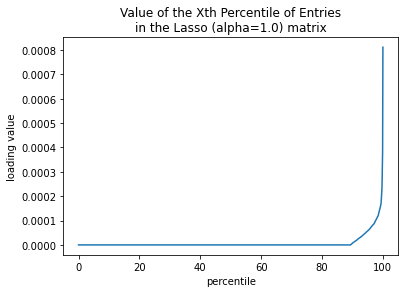

In [59]:
xspace = np.arange(0, 100.1, .1)
plt.plot(xspace, np.percentile(np.abs(A_lasso).flatten(), xspace))
plt.title('Value of the Xth Percentile of Entries\nin the Lasso (alpha=1.0) matrix')
plt.xlabel('percentile')
plt.ylabel('loading value')

plt.savefig(save_dir + 'lasso_loading_percentiles-see_uptick_at_90.png',
            dpi=300, bbox_inches='tight')
plt.show()


In [89]:
# pick most important pixels by using some percentile as a treshold

lasso90 = np.percentile(np.abs(A_lasso.flatten()), 90)
lasso95 = np.percentile(np.abs(A_lasso.flatten()), 95)
lasso975 = np.percentile(np.abs(A_lasso.flatten()), 97.5)
lasso99 = np.percentile(np.abs(A_lasso.flatten()), 99)

A_lasso_90 = np.where(np.abs(A_lasso) >= lasso90, A_lasso,  0)
A_lasso_95 = np.where(np.abs(A_lasso) >= lasso95, A_lasso,  0)
A_lasso_975 = np.where(np.abs(A_lasso) >= lasso975, A_lasso,  0)
A_lasso_99 = np.where(np.abs(A_lasso) >= lasso99, A_lasso,  0)

lasso_labs_90 = A_lasso_90 @ test_imgs.T
lasso_labs_95 = A_lasso_95 @ test_imgs.T
lasso_labs_975 = A_lasso_975 @ test_imgs.T
lasso_labs_99 = A_lasso_99 @ test_imgs.T


lasso_lab_list = [lasso_labs_1, lasso_labs_90, lasso_labs_95, lasso_labs_975,
                  lasso_labs_99]

lasso_corr_counts = [[]]*len(lasso_lab_list)
lasso_wrong_counts = [[]]*len(lasso_lab_list)

for i in range(len(lasso_lab_list)):
    lasso_corr_counts[i], lasso_wrong_counts[i] = check_accuracy(lasso_lab_list[i], test_labs)
    

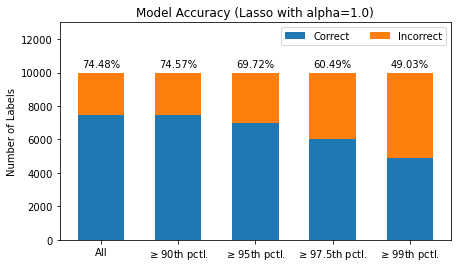

In [93]:
fig, ax = plt.subplots(figsize=(7, 4))

inds = np.arange(len(lasso_corr_counts))
width = 0.6

rects1 = ax.bar(inds, lasso_corr_counts, width, color='C0')
rects2 = ax.bar(inds, lasso_wrong_counts, width, bottom=lasso_corr_counts, color='C1')

ax.set_xticks(np.arange(0, len(lasso_corr_counts)))
ax.set_xticklabels(['All', '$\geq$90th pctl.', '$\geq$95th pctl.',
                    '$\geq$97.5th pctl.', '$\geq$99th pctl.'])

ax.set_ylabel('Number of Labels')
plt.legend([rects1[0], rects2[0]], ['Correct', 'Incorrect'], loc='upper right', ncol=2)
ax.set_title('Model Accuracy (Lasso with alpha=1.0)')
ax.set_ylim(0, 13000)


# label for accuracy
# https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
accuracy = [(lasso_corr_counts[i]/(lasso_corr_counts[i]+lasso_wrong_counts[i]))*100. for i in range(len(lasso_corr_counts))]
accuracy_labs = ['{:.2f}%'.format(x) for x in accuracy]
for i in range(len(rects2)):
    height = rects1[i].get_height() + rects2[i].get_height()
    ax.annotate(accuracy_labs[i],
                xy=(rects2[i].get_x() + rects2[i].get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points',
                ha='center', va='bottom')

plt.savefig(save_dir + 'lasso_pctl_accuracy_comparison.png', dpi=300, bbox_inches='tight')

plt.show()


# 4. Redo the analysis with each digit individually to find the most important pixels for each digit.
* ~~need to modify the B matrix for each digit...~~
* ~~... and then need to modify the method somehow? Like how you test the accuracy?~~
* try the two percentile plots for lasso... see where the cutoff should be for EACH DIGIT
    * for each digit: make a panel plot with bar on the left and cutoff on the right

### NOT SURE WHAT ELSE TO DO????

In [31]:
def check_accuracy_digit(labels, truth):
    """
    Returns the number of correct and incorrect labels. # wrong is the
    number of times the model identifies the digit when it's not, not
    (len(truth) - n_right).
        labels = 2D matrix of size (10, #samples) of the modeled labels
        truth = 1D list of the actual labels (0-9)
    Ex: [n_right, n_wrong] = check_accuracy(lasso_digit_labels, test_labs)
    """
    n_right = 0
    n_wrong = 0
    
    for i in range(len(labels)):
        if truth[i] == 1 and labels[i] == 1:
                n_right += 1
        elif labels[i] == 1 and truth[i] != 1:
                n_wrong += 1
            
    return [n_right, n_wrong]


### 4. (a) all pixels, lasso 1

#### Change the B vectors to be specific for each digit

In [32]:
B_0 = np.where(train_labs==0, 1, 0)
B_1 = np.where(train_labs==1, 1, 0)
B_2 = np.where(train_labs==2, 1, 0)
B_3 = np.where(train_labs==3, 1, 0)
B_4 = np.where(train_labs==4, 1, 0)
B_5 = np.where(train_labs==5, 1, 0)
B_6 = np.where(train_labs==6, 1, 0)
B_7 = np.where(train_labs==7, 1, 0)
B_8 = np.where(train_labs==8, 1, 0)
B_9 = np.where(train_labs==9, 1, 0)

B_list = [B_1, B_2, B_3, B_4, B_5, B_6, B_7, B_8,
          B_9, B_0]


#### Generate the loadings matrix for all digits (using all pixels)

In [33]:
A_lasso_digits = [[]]*10
lasso_digit_labels = [[]]*10

for i in range(10):
    lasso_digit = linear_model.Lasso().fit(train_imgs, B_list[i])
    A_lasso_digits[i] = lasso_digit.coef_
    lasso_digit_labels[i] = np.sign(A_lasso_digits[i] @ test_imgs.T)


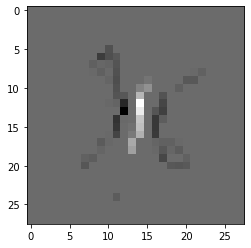

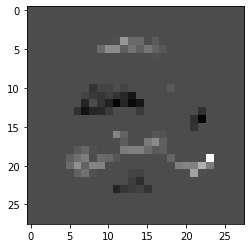

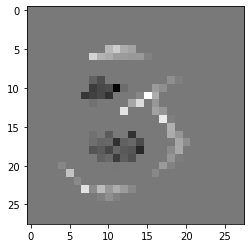

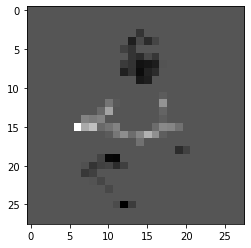

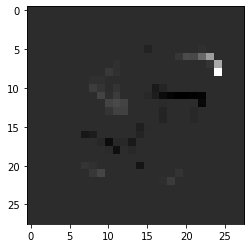

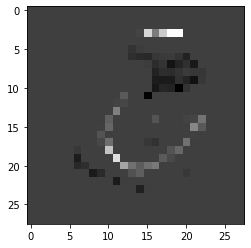

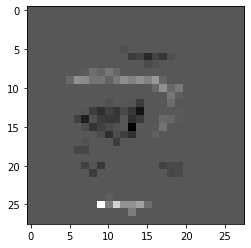

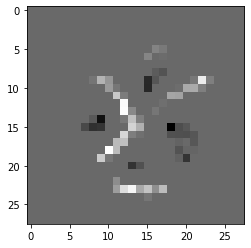

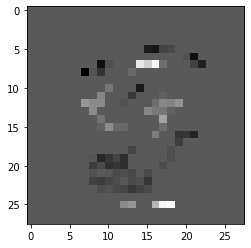

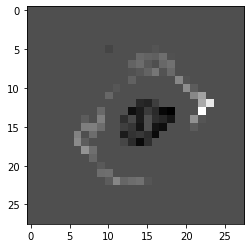

In [35]:
# quick look at the A matrices (but they're exactly the same as before!)

for x in A_lasso_digits:
    plt.imshow(reshape_pic(x), cmap='gray')
    plt.show()
    

### plot accuracy **for each digit** using all pixels

In [34]:
test_labs_0 = np.where(test_labs == 0, 1, 0)
test_labs_1 = np.where(test_labs == 1, 1, 0)
test_labs_2 = np.where(test_labs == 2, 1, 0)
test_labs_3 = np.where(test_labs == 3, 1, 0)
test_labs_4 = np.where(test_labs == 4, 1, 0)
test_labs_5 = np.where(test_labs == 5, 1, 0)
test_labs_6 = np.where(test_labs == 6, 1, 0)
test_labs_7 = np.where(test_labs == 7, 1, 0)
test_labs_8 = np.where(test_labs == 8, 1, 0)
test_labs_9 = np.where(test_labs == 9, 1, 0)

test_lab_list = [test_labs_1, test_labs_2, test_labs_3, test_labs_4,
                 test_labs_5, test_labs_6, test_labs_7, test_labs_8,
                 test_labs_9, test_labs_0]


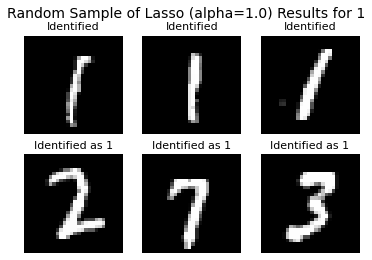

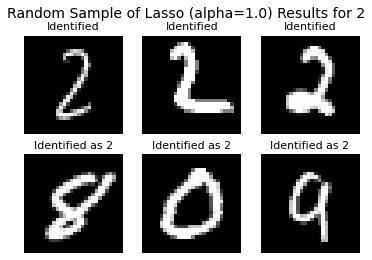

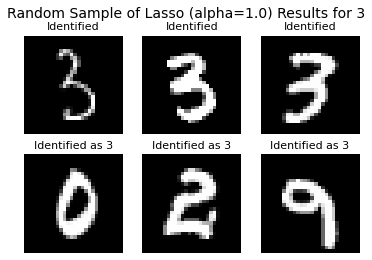

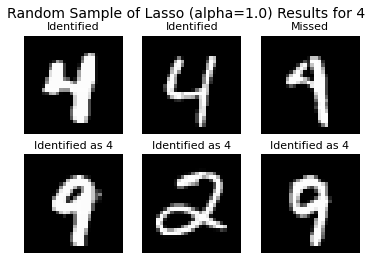

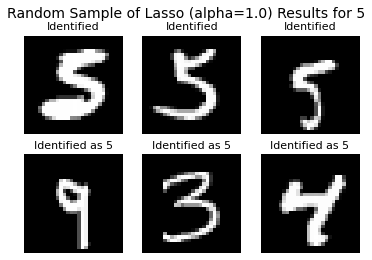

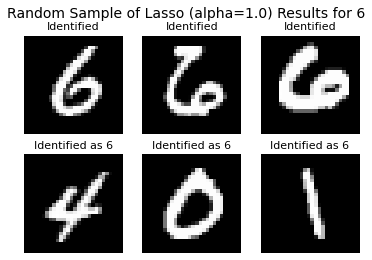

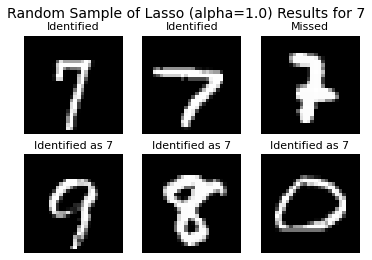

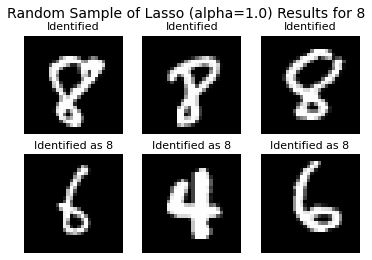

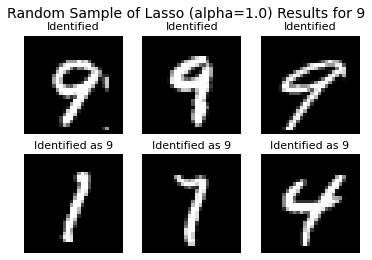

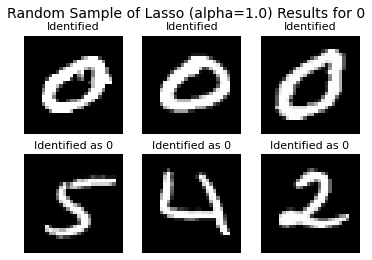

In [106]:
# plot the first few to see how they look

for j in range(10):
    if j == 9:
        num = 0
    else:
        num = j+1
        
    # indices where the picture is of digit #num  
    digit_inds = np.where(test_lab_list[j] == 1)[0]
    not_digit_inds = np.where(test_lab_list[j] != 1)[0]

    # indices where there is a false positive of digit #num
    not_digit_inds = np.where(test_lab_list[j] != 1)[0]
    false_pos_inds = []
    for n in not_digit_inds:
        if lasso_digit_labels[j][n] == 1:
            false_pos_inds.append(n)
    
    for i in range(3):
        # randomly select a digit out of the list
        ind = random.choice(digit_inds)
        
        ax = plt.subplot(2, 3, i+1)
        ax.imshow(reshape_pic(test_imgs[ind]), cmap='gray')
        if lasso_digit_labels[j][ind] == 1:
            ax.set_title('Identified', fontsize=11)
        else:
            ax.set_title('Missed', fontsize=11)
        ax.axis('off')

    for k in range(3, 6):
        # randomly select a digit out of the list
        ind = random.choice(false_pos_inds)
        
        ax = plt.subplot(2, 3, k+1)
        ax.imshow(reshape_pic(test_imgs[ind]), cmap='gray')
        ax.set_title('Identified as {}'.format(num), fontsize=11)
        ax.axis('off')        
    
    plt.suptitle('Random Sample of Lasso (alpha=1.0) Results for {}'.format(num),
                 fontsize=14)
    name = 'ALL_PIXELS_ex_of_correct_and_false_pos_for_{}'.format(num)
    plt.savefig(save_dir + name, dpi=300, bbox_inches='tight')
    
    plt.show()


In [299]:
corr_list_digit = [[]]*10
wrong_list_digit = [[]]*10
accuracy_digit_list = [[]]*10
false_pos_list = [[]]*10
true_pos_list = [[]]*10

for i in range(10):
    if i == 9:
        n = 0
    else:
        n = i+1
    corr_list_digit[i], wrong_list_digit[i] = check_accuracy_digit(lasso_digit_labels[i],
                                                                   test_lab_list[i])
    
    # how often the digit was identified correctly and the not-digits were
    # identified correctly
    accuracy_digit_list[i] = corr_list_digit[i]/(corr_list_digit[i] + wrong_list_digit[i])*100.
    
    fp = 0
    tp = 0
    for j in range(ntest):
        if lasso_digit_labels[i][j] == 1 and test_lab_list[i][j] != 1:
            fp += 1
        elif lasso_digit_labels[i][j] == 1 and test_lab_list[i][j] == 1:
            tp += 1
    
    # how often the digit was identified when it wasn't the true label
    # and how often the digit was identified correctly
    false_pos_list[i] = fp/ntest*100.
    true_pos_list[i] = tp/np.sum(test_lab_list[i])*100.
    
    print('{n}: {a}% correct'.format(n=n, a=accuracy_digit_list[i]))
    print('{n}: {f}% false positives'.format(n=n, f=false_pos_list[i]))
    print('{n}: {t}% true positives'.format(n=n, t=true_pos_list[i]))
    

1: 55.09803921568628% correct
1: 9.16% false positives
1: 99.03083700440529% true positives
2: 16.63408276311502% correct
2: 51.17% false positives
2: 98.93410852713178% true positives
3: 15.269734836939957% correct
3: 55.60000000000001% false positives
3: 99.20792079207921% true positives
4: 28.959952181709504% correct
4: 23.77% false positives
4: 98.67617107942974% true positives
5: 35.03649635036496% correct
5: 15.129999999999999% false positives
5: 91.4798206278027% true positives
6: 20.298826040554964% correct
6: 37.34% false positives
6: 99.26931106471815% true positives
7: 42.18816517667092% correct
7: 13.58% false positives
7: 96.40077821011673% true positives
8: 10.017484315540472% correct
8: 87.49% false positives
8: 100.0% true positives
9: 16.244725738396625% correct
9: 51.61% false positives
9: 99.20713577799802% true positives
0: 36.72699849170438% correct
0: 16.78% false positives
0: 99.38775510204081% true positives


##### Bar chart for the accuracy/false positive stuff by digit
This will show how often
* the digit was **identified correctly** _**and**_ the non-digits were identified correctly (denom = # of instances of that digit in the testing dataset)
* the incidence of **"false positives"** (the model identified the digit when it wasn't actually there) out of the whole testing set (denom=10,000)
* the incidence of **"true positives"** (the model identified the digit when it was there) (denom = # of instances of that digit in the testing dataset)


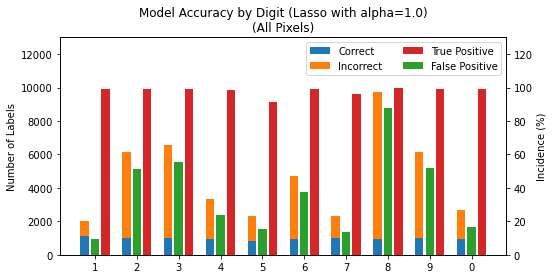

In [37]:
fig, ax = plt.subplots(figsize=(8, 4))

inds = np.arange(10)
width = 0.2

rects_corr = ax.bar(inds, corr_list_digit, width, color='C0')
rects_wrong = ax.bar(inds, wrong_list_digit, width, bottom=corr_list_digit, color='C1')

ax.set_xticks(np.arange(0.25, 10.25))
ax.set_xticklabels([*np.arange(1, 10), 0])
ax.set_ylabel('Number of Labels')
ax.set_ylim(0, 13000)

ax2 = ax.twinx()
ax2.set_ylabel('Incidence (%)')
ax2.set_ylim(0, 130)
rects_tp = ax2.bar(inds+0.5, true_pos_list, width, color='C3')
rects_fp = ax2.bar(inds+0.25, false_pos_list, width, color='C2')

plt.legend([rects_corr[0], rects_wrong[0], rects_tp[0], rects_fp[0]],
           ['Correct', 'Incorrect', 'True Positive', 'False Positive'],
           loc='upper right', ncol=2)
ax.set_title('Model Accuracy by Digit (Lasso with alpha=1.0)\n(All Pixels)')

plt.savefig(save_dir + 'DIGIT_ALL_PIXELS_lasso_accuracy_comparison.png', dpi=300, bbox_inches='tight')

plt.show()


##### Make a table of the percentages

In [300]:
dig_list = [*np.arange(1, 10), 0]
acc_labs_dig = ['{:.1f}%'.format(x) for x in accuracy_digit_list]
fp_labs = ['{:.1f}%'.format(x) for x in false_pos_list]
tp_labs = ['{:.1f}%'.format(x) for x in true_pos_list]

cols = [[]]*10
for i in range(10):
    cols[i] = [dig_list[i], acc_labs_dig[i], tp_labs[i], fp_labs[i]]

print('All Pixels:')
print(tabulate(cols, ['Digit', 'Accuracy', 'True Positive Rate', 'False Positive Rate'],
               tablefmt='fancy_grid'))


All Pixels:
╒═════════╤════════════╤══════════════════════╤═══════════════════════╕
│   Digit │ Accuracy   │ True Positive Rate   │ False Positive Rate   │
╞═════════╪════════════╪══════════════════════╪═══════════════════════╡
│       1 │ 55.1%      │ 99.0%                │ 9.2%                  │
├─────────┼────────────┼──────────────────────┼───────────────────────┤
│       2 │ 16.6%      │ 98.9%                │ 51.2%                 │
├─────────┼────────────┼──────────────────────┼───────────────────────┤
│       3 │ 15.3%      │ 99.2%                │ 55.6%                 │
├─────────┼────────────┼──────────────────────┼───────────────────────┤
│       4 │ 29.0%      │ 98.7%                │ 23.8%                 │
├─────────┼────────────┼──────────────────────┼───────────────────────┤
│       5 │ 35.0%      │ 91.5%                │ 15.1%                 │
├─────────┼────────────┼──────────────────────┼───────────────────────┤
│       6 │ 20.3%      │ 99.3%                │ 37.3

### 4. (b) now pick the most important pixels for each digit

#### Test the cutoff with Lasso (alpha = 1.0)
See accuracy with all points, 90th, 95th, 97th, 99th
(and note that anything below the ~89.5th percentile for this one is 0, so it wouldn't be included anyway)

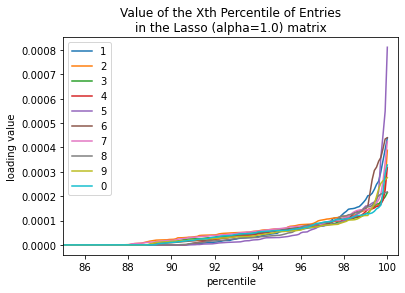

In [183]:
xspace = np.arange(0, 100.1, .1)

for i in range(10):
    if i == 9:
        num = 0
    else:
        num = i + 1
    plt.plot(xspace, np.percentile(np.abs(A_lasso_digits[i]).flatten(), xspace),
             label=num)

plt.legend()    
plt.xlim((85, 100.5))
plt.title('Value of the Xth Percentile of Entries\nin the Lasso (alpha=1.0) matrix')
plt.xlabel('percentile')
plt.ylabel('loading value')

plt.savefig(save_dir + 'DIGIT_lasso_loading_percentiles-see_uptick_at_91.png',
            dpi=300, bbox_inches='tight')
plt.show()


In [190]:
# pick most important pixels by using some percentile as a treshold

pct_list = [0, 91, 95, 97.5, 99]
digit_pcts = [[]]*len(pct_list)
new_A_digits = [[]]*len(pct_list)
new_digit_labs = [[]]*len(pct_list)

# 0
digit_pcts[0] = [np.percentile(np.abs(x.flatten()), pct_list[0]) 
                 for x in A_lasso_digits]
new_A_digits[0] = [np.where(np.abs(A_lasso_digits[i]) >= digit_pcts[0][i],
                            A_lasso_digits[i], 0)
                   for i in range(10)]
new_digit_labs[0] = [np.sign(new_A_digits[0][i] @ test_imgs.T)
                     for i in range(10)]

# 91
digit_pcts[1] = [np.percentile(np.abs(x.flatten()), pct_list[1]) 
                 for x in A_lasso_digits]
new_A_digits[1] = [np.where(np.abs(A_lasso_digits[i]) >= digit_pcts[1][i],
                            A_lasso_digits[i], 0)
                   for i in range(10)]
new_digit_labs[1] = [np.sign(new_A_digits[1][i] @ test_imgs.T)
                     for i in range(10)]

# 95
digit_pcts[2] = [np.percentile(np.abs(x.flatten()), pct_list[2]) 
                 for x in A_lasso_digits]
new_A_digits[2] = [np.where(np.abs(A_lasso_digits[i]) >= digit_pcts[2][i],
                            A_lasso_digits[i], 0)
                   for i in range(10)]
new_digit_labs[2] = [np.sign(new_A_digits[2][i] @ test_imgs.T)
                     for i in range(10)]

# 97.5
digit_pcts[3] = [np.percentile(np.abs(x.flatten()), pct_list[3]) 
                 for x in A_lasso_digits]
new_A_digits[3] = [np.where(np.abs(A_lasso_digits[i]) >= digit_pcts[3][i],
                            A_lasso_digits[i], 0)
                   for i in range(10)]
new_digit_labs[3] = [np.sign(new_A_digits[3][i] @ test_imgs.T)
                     for i in range(10)]

# 99
digit_pcts[4] = [np.percentile(np.abs(x.flatten()), pct_list[4]) 
                 for x in A_lasso_digits]
new_A_digits[4] = [np.where(np.abs(A_lasso_digits[i]) >= digit_pcts[4][i],
                            A_lasso_digits[i], 0)
                   for i in range(10)]
new_digit_labs[4] = [np.sign(new_A_digits[4][i] @ test_imgs.T)
                     for i in range(10)]


In [290]:
# get the % accuracy by choice of important pixels

corr_list_digit_pcts = [[]]*len(pct_list)
wrong_list_digit_pcts = [[]]*len(pct_list)
accuracy_digit_list_pcts = [[]]*len(pct_list)
false_pos_list_pcts = [[]]*len(pct_list)
true_pos_list_pcts = [[]]*len(pct_list)

for j in range(len(pct_list)):
    corr_list_dig = [[]]*10
    wrong_list_dig = [[]]*10
    accuracy_digit_list = [[]]*10
    false_pos_dig = [[]]*10
    true_pos_dig = [[]]*10

    for i in range(10):
        corr_list_dig[i], wrong_list_dig[i] = check_accuracy_digit(new_digit_labs[j][i],
                                                                   test_lab_list[i])

        # how often the digit was identified correctly and the not-digits were
        # identified correctly
        accuracy_digit_list[i] = corr_list_dig[i]/(corr_list_dig[i] + wrong_list_dig[i])*100.
        
        fp = 0
        tp = 0
        for k in range(ntest):
            if new_digit_labs[j][i][k] == 1 and test_lab_list[i][k] != 1:
                fp += 1
            elif new_digit_labs[j][i][k] == 1 and test_lab_list[i][k] == 1:
                tp += 1
    
        # how often the digit was identified when it wasn't the true label
        # and how often the digit was identified correctly
        false_pos_dig[i] = fp/ntest*100.
        true_pos_dig[i] = tp/np.sum(test_lab_list[i])*100.
    
    corr_list_digit_pcts[j] = corr_list_dig
    wrong_list_digit_pcts[j] = wrong_list_dig
    accuracy_digit_list_pcts[j] = accuracy_digit_list
    false_pos_list_pcts[j] = false_pos_dig
    true_pos_list_pcts[j] = true_pos_dig

    

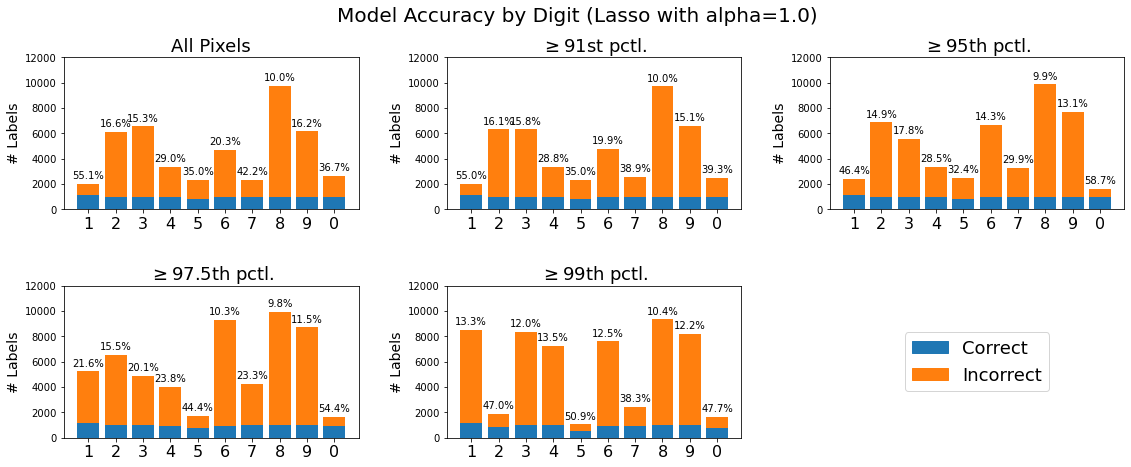

In [283]:
# plot the % accuracy

fig, axes = plt.subplots(2, 3, figsize=(19, 7))
plt.subplots_adjust(hspace=0.5, wspace=0.3)

inds = np.arange(10)
width = 0.8

for r in range(2):
    for c in range(3):
        ax = axes[r, c]
        
        if r == 0:
            i = c
        else:
            i = c+3
        
        if i != 5:  
            rects_corr = ax.bar(inds, corr_list_digit_pcts[i], width, color='C0')
            rects_wrong = ax.bar(inds, wrong_list_digit_pcts[i], width, bottom=corr_list_digit_pcts[i], color='C1')

            ax.set_xticks(np.arange(0, 10))
            ax.set_xticklabels([*np.arange(1, 10), 0], fontsize=16)
            ax.set_ylabel('# Labels', fontsize=14)
            ax.set_ylim(0, 12000)
            if i == 0:
                ax.set_title('All Pixels', fontsize=18)
            elif i == 1:
                ax.set_title('$\geq${}st pctl.'.format(pct_list[i]), fontsize=18)
            else:
                ax.set_title('$\geq${}th pctl.'.format(pct_list[i]), fontsize=18)

            # label for accuracy
            # https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
            acc_labs_pct = ['{:.1f}%'.format(x) for x in accuracy_digit_list_pcts[i]]
            for j in range(len(rects_corr)):
                height = rects_corr[j].get_height() + rects_wrong[j].get_height()
                ax.annotate(acc_labs_pct[j],
                            xy=(rects_corr[j].get_x() + rects_wrong[j].get_width() / 2, height),
                            xytext=(0, 3), textcoords='offset points',
                            ha='center', va='bottom')
            
        else:
        # proxy legend
            ax.axis('off')
            corr_patch = mpatches.Patch(color='C0', label='Correct')
            wrong_patch = mpatches.Patch(color='C1', label='Incorrect')
            ax.legend(handles=[corr_patch, wrong_patch], fontsize=18,
                      loc='center')

plt.suptitle('Model Accuracy by Digit (Lasso with alpha=1.0)', fontsize=20)

plt.savefig(save_dir + 'DIGIT_PCTS_lasso_accuracy_comparison.png', dpi=300, bbox_inches='tight')

plt.show()


In [294]:
dig_list = [*np.arange(1, 10), 0]
acc_labs_dig = ['{:.1f}%'.format(x) for x in accuracy_digit_list_pcts[1]]
fp_labs = ['{:.1f}%'.format(x) for x in false_pos_list_pcts[1]]
tp_labs = ['{:.1f}%'.format(x) for x in true_pos_list_pcts[1]]

cols = [[]]*10
for i in range(10):
    cols[i] = [dig_list[i], acc_labs_dig[i], tp_labs[i], fp_labs[i]]

print('>= 91st percentile')
print(tabulate(cols, ['Digit', 'Accuracy', 'True Positive Rate', 'False Positive Rate'],
               tablefmt='fancy_grid'))


>= 91st percentile
╒═════════╤════════════╤══════════════════════╤═══════════════════════╕
│   Digit │ Accuracy   │ True Positive Rate   │ False Positive Rate   │
╞═════════╪════════════╪══════════════════════╪═══════════════════════╡
│       1 │ 55.0%      │ 99.0%                │ 9.2%                  │
├─────────┼────────────┼──────────────────────┼───────────────────────┤
│       2 │ 16.1%      │ 98.8%                │ 53.1%                 │
├─────────┼────────────┼──────────────────────┼───────────────────────┤
│       3 │ 15.8%      │ 98.9%                │ 53.1%                 │
├─────────┼────────────┼──────────────────────┼───────────────────────┤
│       4 │ 28.8%      │ 98.7%                │ 23.9%                 │
├─────────┼────────────┼──────────────────────┼───────────────────────┤
│       5 │ 35.0%      │ 91.5%                │ 15.1%                 │
├─────────┼────────────┼──────────────────────┼───────────────────────┤
│       6 │ 19.9%      │ 99.3%               

In [295]:
dig_list = [*np.arange(1, 10), 0]
acc_labs_dig = ['{:.1f}%'.format(x) for x in accuracy_digit_list_pcts[2]]
fp_labs = ['{:.1f}%'.format(x) for x in false_pos_list_pcts[2]]
tp_labs = ['{:.1f}%'.format(x) for x in true_pos_list_pcts[2]]

cols = [[]]*10
for i in range(10):
    cols[i] = [dig_list[i], acc_labs_dig[i], tp_labs[i], fp_labs[i]]

print('>= 95th percentile')
print(tabulate(cols, ['Digit', 'Accuracy', 'True Positive Rate', 'False Positive Rate'],
               tablefmt='fancy_grid'))


>= 95th percentile
╒═════════╤════════════╤══════════════════════╤═══════════════════════╕
│   Digit │ Accuracy   │ True Positive Rate   │ False Positive Rate   │
╞═════════╪════════════╪══════════════════════╪═══════════════════════╡
│       1 │ 46.4%      │ 99.4%                │ 13.1%                 │
├─────────┼────────────┼──────────────────────┼───────────────────────┤
│       2 │ 14.9%      │ 98.9%                │ 58.4%                 │
├─────────┼────────────┼──────────────────────┼───────────────────────┤
│       3 │ 17.8%      │ 98.2%                │ 45.9%                 │
├─────────┼────────────┼──────────────────────┼───────────────────────┤
│       4 │ 28.5%      │ 97.6%                │ 24.0%                 │
├─────────┼────────────┼──────────────────────┼───────────────────────┤
│       5 │ 32.4%      │ 91.1%                │ 17.0%                 │
├─────────┼────────────┼──────────────────────┼───────────────────────┤
│       6 │ 14.3%      │ 99.4%               

In [296]:
dig_list = [*np.arange(1, 10), 0]
acc_labs_dig = ['{:.1f}%'.format(x) for x in accuracy_digit_list_pcts[3]]
fp_labs = ['{:.1f}%'.format(x) for x in false_pos_list_pcts[3]]
tp_labs = ['{:.1f}%'.format(x) for x in true_pos_list_pcts[3]]

cols = [[]]*10
for i in range(10):
    cols[i] = [dig_list[i], acc_labs_dig[i], tp_labs[i], fp_labs[i]]

print('>= 97.5th percentile')
print(tabulate(cols, ['Digit', 'Accuracy', 'True Positive Rate', 'False Positive Rate'],
               tablefmt='fancy_grid'))


>= 97.5th percentile
╒═════════╤════════════╤══════════════════════╤═══════════════════════╕
│   Digit │ Accuracy   │ True Positive Rate   │ False Positive Rate   │
╞═════════╪════════════╪══════════════════════╪═══════════════════════╡
│       1 │ 21.6%      │ 99.8%                │ 41.2%                 │
├─────────┼────────────┼──────────────────────┼───────────────────────┤
│       2 │ 15.5%      │ 98.3%                │ 55.4%                 │
├─────────┼────────────┼──────────────────────┼───────────────────────┤
│       3 │ 20.1%      │ 97.0%                │ 38.9%                 │
├─────────┼────────────┼──────────────────────┼───────────────────────┤
│       4 │ 23.8%      │ 96.6%                │ 30.4%                 │
├─────────┼────────────┼──────────────────────┼───────────────────────┤
│       5 │ 44.4%      │ 85.9%                │ 9.6%                  │
├─────────┼────────────┼──────────────────────┼───────────────────────┤
│       6 │ 10.3%      │ 99.9%             

In [297]:
dig_list = [*np.arange(1, 10), 0]
acc_labs_dig = ['{:.1f}%'.format(x) for x in accuracy_digit_list_pcts[4]]
fp_labs = ['{:.1f}%'.format(x) for x in false_pos_list_pcts[4]]
tp_labs = ['{:.1f}%'.format(x) for x in true_pos_list_pcts[4]]

cols = [[]]*10
for i in range(10):
    cols[i] = [dig_list[i], acc_labs_dig[i], tp_labs[i], fp_labs[i]]

print('>= 99th percentile')
print(tabulate(cols, ['Digit', 'Accuracy', 'True Positive Rate', 'False Positive Rate'],
               tablefmt='fancy_grid'))


>= 99th percentile
╒═════════╤════════════╤══════════════════════╤═══════════════════════╕
│   Digit │ Accuracy   │ True Positive Rate   │ False Positive Rate   │
╞═════════╪════════════╪══════════════════════╪═══════════════════════╡
│       1 │ 13.3%      │ 99.9%                │ 73.8%                 │
├─────────┼────────────┼──────────────────────┼───────────────────────┤
│       2 │ 47.0%      │ 85.8%                │ 10.0%                 │
├─────────┼────────────┼──────────────────────┼───────────────────────┤
│       3 │ 12.0%      │ 99.3%                │ 73.6%                 │
├─────────┼────────────┼──────────────────────┼───────────────────────┤
│       4 │ 13.5%      │ 99.5%                │ 62.7%                 │
├─────────┼────────────┼──────────────────────┼───────────────────────┤
│       5 │ 50.9%      │ 60.0%                │ 5.2%                  │
├─────────┼────────────┼──────────────────────┼───────────────────────┤
│       6 │ 12.5%      │ 99.4%               

# TODO: ANYTHING ELSE???
Why is the accuracy by digit so weird??

# 5. IMPORTANT: Think about the interpretation of what you are doing with this AX = B problem.
(I think you'll just write something about interpreting the results...)